# *eht-imaging* Tutorial $-$ ngEHT November 2021 Meeting

---

`eht-imaging` is a Python software for radio interferometric simulation, calibration, analysis, and imaging. Code and documentation can be found on [GitHub](https://github.com/achael/eht-imaging)

This notebook is a simplified version of the imaging process employed by the `eht-imaging` script from the *First M87 EHT Results: Imaging Pipelines* public repository that can be found on [GitHub](https://github.com/eventhorizontelescope/2019-D01-02).

## Prerequisites
Running this notebook requires that `eht-imaging` and its dependencies are installed (see README on [GitHub](https://github.com/achael/eht-imaging)). If you do not have `nfft` installed, you can set `ttype=fast` in the following.

## Import necessary modules

In [2]:
import os
import ehtim as eh
import numpy as np
import matplotlib.pyplot as plt

Welcome to eht-imaging! v 1.2.3 



## Define paths

In [7]:
inpath  = 'data'
outpath = 'results/M87_ngeht_ref1_230_thnoise'
inobs   = os.path.join(inpath, 'M87_ngeht_ref1_230_thnoise.uvfits')

# Make output directories
if not os.path.exists(os.path.dirname(outpath)):
    os.makedirs(os.path.dirname(outpath))

## Imaging parameters

In [8]:
prior_fwhm  = 100.*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise   = 0.01               # fractional systematic noise
                                 # added to complex visibilities

reg_term  = {'simple' : 0,       # Maximum-Entropy
             'tv'     : 1,       # Total Variation
             'tv2'    : 0,       # Total Squared Variation
             'l1'     : 1.,      # L1 sparsity prior
             'flux'   : 0.}      # compact flux constraint

data_term = {'amp'    : 1.,      # visibility amplitudes
             'cphase' : 1.,      # closure phases
             'logcamp': 1.}      # log closure amplitudes

ttype     = 'nfft'               # Type of Fourier transform ('direct', 'nfft', or 'fast')
npix      = 100                  # Number of pixels across the reconstructed image
fov       = 700*eh.RADPERUAS     # Field of view of the reconstructed image
maxit     = 350                  # Maximum number of convergence iterations for imaging
niter     = 4                    # Number of imaging iterations
stop      = 1e-6                 # Imager stopping criterion

## Helper function

In [9]:
# Repeat imaging with blurring to assure good convergence
def converge(major=niter, blur_frac=1.0):
    for repeat in range(major):
        init = imgr.out_last().blur_circ(blur_frac*res)
        imgr.init_next = init
        imgr.make_image_I(show_updates=False)
        imgr.out_last().display(scale='log')

## Data preparation

In [10]:
# Load the uvfits file
obs = eh.obsdata.load_uvfits(inobs)

# Scan-average the data
# Identify the scans (times of continous observation) in the data
obs.add_scans()

# Coherently average the scans, which can be averaged due to ad-hoc phasing
obs = obs.avg_coherent(0., scan_avg=True)

# Estimate the total flux density from the ALMA(AA) -- APEX(AP) zero baseline
zbl = np.median(obs.unpack_bl('AA','AP','amp')['amp'])

# Flag out sites in the obs.tarr table with no measurements
allsites = set(obs.unpack(['t1'])['t1'])|set(obs.unpack(['t2'])['t2'])
obs.tarr = obs.tarr[[o in allsites for o in obs.tarr['site']]]
obs = eh.obsdata.Obsdata(obs.ra, obs.dec, obs.rf, obs.bw, obs.data, obs.tarr,
                         source=obs.source, mjd=obs.mjd,
                         ampcal=obs.ampcal, phasecal=obs.phasecal)

obs_orig = obs.copy() # save obs before any further modifications

# Order the stations by SNR.
# This will create a minimal set of closure quantities
# with the highest snr and smallest covariance.
obs.reorder_tarr_snr()

Loading uvfits:  data/M87_ngeht_ref1_230_thnoise.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!


/home/ptiede/.local/lib/python3.9/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


## Data inspection

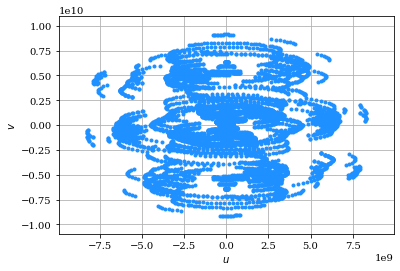

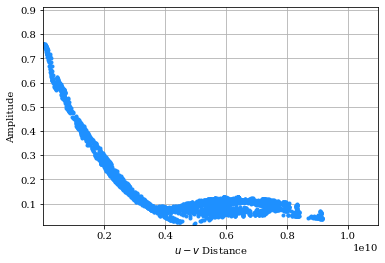

<AxesSubplot:xlabel='$u-v$ Distance', ylabel='Amplitude'>

In [11]:
# Plot uv-coverage
obs.plotall('u', 'v', conj=True, export_pdf='uv.pdf')

# Plot visibility amplitudes, phases, etc. as a function of uv distance
obs.plotall('uvdist', 'amp', export_pdf='amps.pdf')

# Plot baselines
#obs.plot_bl('AA', 'SM', 'phase', rangex=[4., 10])

## Define prior/init and noise budget

prior total flux: 0.76 Jy


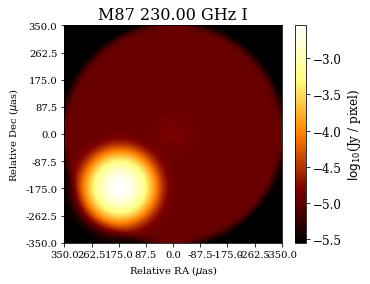

In [12]:
obs_sc = obs.copy() # From here on out, don't change obs. Use obs_sc to track gain changes
res    = obs.res()  # The nominal array resolution: 1/(longest baseline)

# Make a Gaussian prior image for maximum entropy regularization
# This Gaussian is also the initial image
gaussprior = eh.image.make_square(obs_sc, npix, fov)
gaussprior = gaussprior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0.,
                                        170*eh.RADPERUAS, -170*eh.RADPERUAS))

# Add a large disk to capture extended emission
gaussprior = gaussprior.add_tophat(zbl*0.1, fov/2).blur_circ(res)

# To avoid gradient singularities in the first step, add an additional small Gaussian
gaussprior = gaussprior.add_gauss(zbl*1e-3, (prior_fwhm, prior_fwhm, 0, 0, 0))

# Rescale the prior flux so it matches the measured zbl flux
gaussprior.imvec *= zbl / gaussprior.total_flux()

print('prior total flux: {:.2f} Jy'.format(gaussprior.total_flux()))
gaussprior.display(scale='log')

# Add non-closing systematic noise to the observation
obs_sc = obs_sc.add_fractional_noise(sys_noise)

# Make a copy of the initial data (before any self-calibration but after the taper)
obs_sc_init = obs_sc.copy()

## Image reconstruction

Round 1: Imaging with complex visibilities amplitudes and closure quantities...
Initializing imager data products . . .


/home/ptiede/.local/lib/python3.9/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


Imager run 1 
time: 9.446460 s
J: 5.376279
chi2_amp : 1.52 chi2_cphase : 2.02 chi2_logcamp : 0.92 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


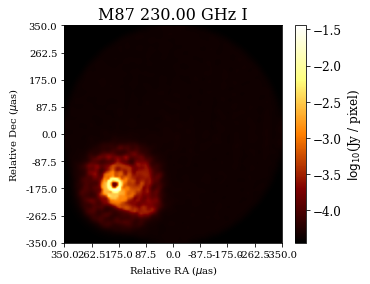

Imager run 2 
time: 103.871445 s
J: 4.372220
chi2_amp : 1.11 chi2_cphase : 1.76 chi2_logcamp : 0.61 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


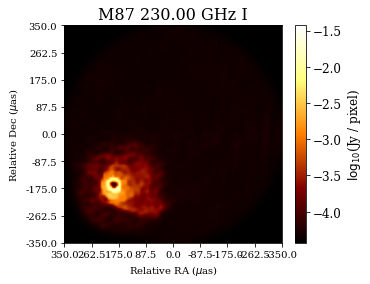

Imager run 3 
time: 53.155272 s
J: 3.920815
chi2_amp : 0.88 chi2_cphase : 1.65 chi2_logcamp : 0.50 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


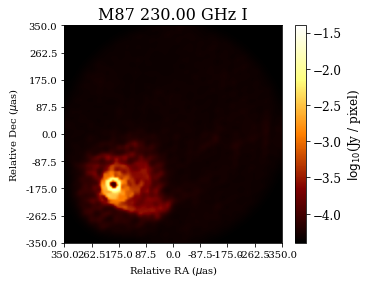

Imager run 4 
time: 11.227041 s
J: 3.641669
chi2_amp : 0.74 chi2_cphase : 1.57 chi2_logcamp : 0.43 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


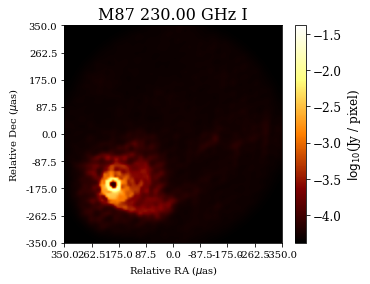

Imager run 5 
time: 12.338518 s
J: 3.470950
chi2_amp : 0.66 chi2_cphase : 1.54 chi2_logcamp : 0.40 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


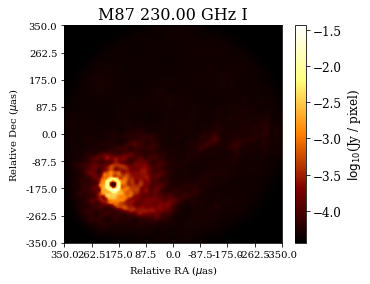

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with nfft Fourier Transform...
Producing clean visibilities from image with nfft FT . . . 
Using Multiprocessing with 4 Processes
Scan 67/67 : [------------------------------]100%
self_cal time: 34.915684 s


/home/ptiede/.local/lib/python3.9/site-packages/ehtim/calibrating/self_cal.py:134: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  scans_cal = np.array(pool.map(get_selfcal_scan_cal, [[i, len(scans), scans[i],


In [13]:
# First  Round of Imaging
# ·······················
print("Round 1: Imaging with complex visibilities amplitudes and closure quantities...")

# Initialize imaging with a Gaussian image
imgr = eh.imager.Imager(obs_sc, gaussprior, prior_im=gaussprior,
                        flux=zbl, data_term=data_term, maxit=maxit,
                        norm_reg=True, reg_term=reg_term, ttype=ttype,
                        stop=stop)

# Imaging
imgr.make_image_I(show_updates=False)
imgr.out_last().display(scale='log')
converge()

# Self-calibrate to the previous model
obs_sc = eh.selfcal(obs_sc_init, imgr.out_last(), method='both', ttype=ttype,
                    solution_interval=0.0, processes=0)

Round 2: Imaging with visibilities and closure quantities...
Initializing imager data products . . .
Imager run 1 
time: 9.248688 s
J: 1.703883
chi2_cphase : 1.36 chi2_logcamp : 0.39 chi2_vis : 0.99 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Imager run 2 
time: 9.583737 s
J: 0.811576
chi2_cphase : 1.32 chi2_logcamp : 0.38 chi2_vis : 0.96 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


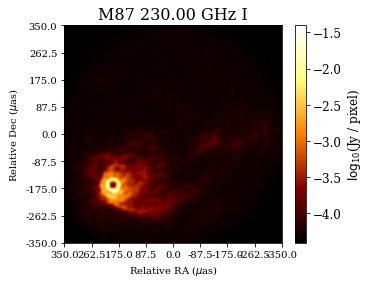

Imager run 3 
time: 11.025734 s
J: 0.245297
chi2_cphase : 1.29 chi2_logcamp : 0.37 chi2_vis : 0.95 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


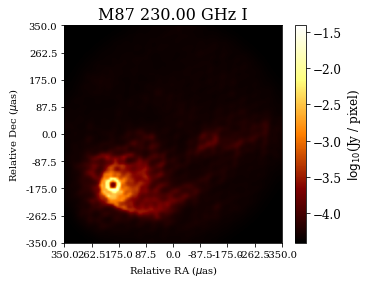

Imager run 4 
time: 22.801605 s
J: 0.079714
chi2_cphase : 1.28 chi2_logcamp : 0.37 chi2_vis : 0.94 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


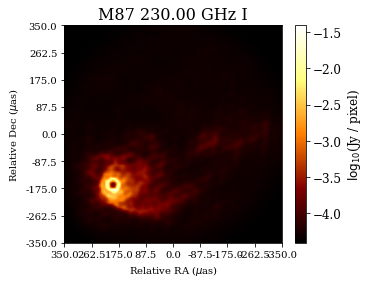

Imager run 5 
time: 48.314882 s
J: -0.048237
chi2_cphase : 1.28 chi2_logcamp : 0.36 chi2_vis : 0.94 
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


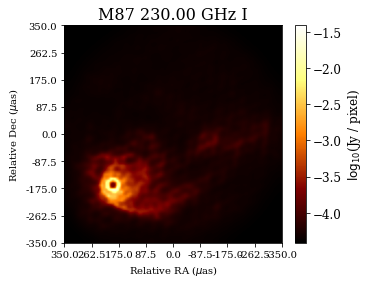

No stations specified in self cal: defaulting to calibrating all stations!
Computing the Model Visibilities with nfft Fourier Transform...
Producing clean visibilities from image with nfft FT . . . 
Using Multiprocessing with 4 Processes
Scan 67/67 : [------------------------------]100%
self_cal time: 35.001731 s


In [14]:
# Second  Round of Imaging
# ························
print("Round 2: Imaging with visibilities and closure quantities...")

# Blur the previous reconstruction to the intrinsic resolution of ~25 uas
init = imgr.out_last().blur_circ(res)

# Increase the weights on the data terms and reinitialize imaging
data_term_intermediate = {'vis':imgr.dat_terms_last()['amp']*10,
                          'cphase':imgr.dat_terms_last()['cphase']*10,
                          'logcamp':imgr.dat_terms_last()['logcamp']*10}


imgr = eh.imager.Imager(obs_sc, init, prior_im=gaussprior, flux=zbl,
                        data_term=data_term_intermediate, maxit=maxit, 
                        norm_reg=True, reg_term=reg_term, ttype=ttype,
                        stop=stop)

# Imaging
imgr.make_image_I(show_updates=False)
converge()

# Self-calibrate to the previous model starting from scratch
obs_sc = eh.selfcal(obs_sc_init, imgr.out_last(), method='both', ttype=ttype,
                    solution_interval=0.0, processes=0)

## Output the results

Building NX table
No NX table in saved uvfits


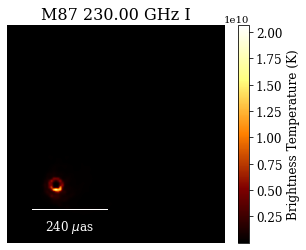

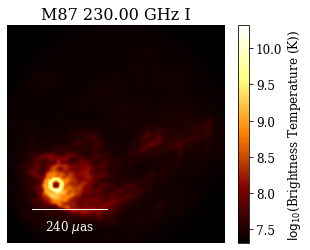

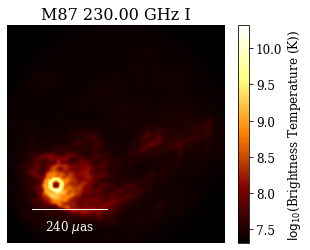

In [15]:
# Save the reconstructed image
im_out = imgr.out_last().copy()
obs_sc_final = obs_sc.copy()

# Save the final image
im_out.save_fits(outpath+'.fits')
obs_sc_final.save_uvfits(outpath+'.uvfits')

# Save a png of the final image
im_out.display(cbar_unit=['Tb'], label_type='scale', export_pdf=outpath+'.png')
im_out.display(cbar_unit=['Tb'], label_type='scale', scale='log', export_pdf=outpath+'_logscale.png')

# Generate a summary of the final image and associated data consistency metrics (might take a while)
#eh.imgsum(im_out, obs_sc_final, obs_orig, outpath+'_imgsum.pdf', gainplots=False)

## Check image fit to data

Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 


Warning!: in add_noise, some SEFDs are <= 0!
NOT recomputing sigmas, which may result in double systematic noise


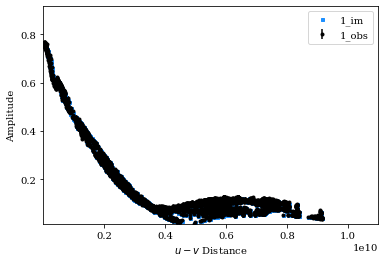

Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 


Warning!: in add_noise, some SEFDs are <= 0!
NOT recomputing sigmas, which may result in double systematic noise


/home/ptiede/.local/lib/python3.9/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)
/home/ptiede/.local/lib/python3.9/site-packages/ehtim/obsdata.py:508: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


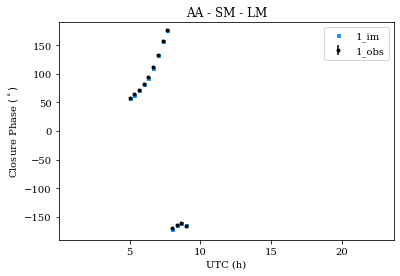

<AxesSubplot:title={'center':'AA - SM - LM'}, xlabel='UTC (h)', ylabel='Closure Phase $(^\\circ)$'>

In [16]:
# Plot self-calibrated visibility amplitudes and image model
eh.plotall_obs_im_compare(obs_sc_final, im_out, 'uvdist', 'amp')

# Plot closure phases and image model
eh.plot_cphase_obs_im_compare(obs_sc_final, im_out, 'AA', 'SM', 'LM')